# Analyzing Amazon Reviews for Grocery and Gourmet Products

Importing Libraries 

In [6]:
import nltk # natural language toolkit
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import json
import string
import re

from nltk.corpus import stopwords
from collections import Counter # to count words in our list
from datetime import datetime
# initialize the analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from nltk import PorterStemmer
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

Include borders on pandas outputs

In [7]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

# Functions to parse through JSON files and create a dataframe

In [8]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.loads(l)

In [9]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

In [10]:
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# Import Data

In [11]:
df = getDF('Grocery_and_Gourmet_Food_5.json.gz')

In [12]:
print(f"Data dimension: {df.shape}")
for col in df.columns:
    print(f"Column: {col:35} | type: {str(df[col].dtype):7} \
| missing values: {df[col].isna().sum():3d}")

Data dimension: (1143860, 12)
Column: overall                             | type: float64 | missing values:   0
Column: verified                            | type: bool    | missing values:   0
Column: reviewTime                          | type: object  | missing values:   0
Column: reviewerID                          | type: object  | missing values:   0
Column: asin                                | type: object  | missing values:   0
Column: reviewerName                        | type: object  | missing values: 138
Column: reviewText                          | type: object  | missing values: 390
Column: summary                             | type: object  | missing values: 219
Column: unixReviewTime                      | type: int64   | missing values:   0
Column: vote                                | type: object  | missing values: 985658
Column: style                               | type: object  | missing values: 551774
Column: image                               | type: object  | 

In [13]:
df.head(10)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,NaN,NaN,NaN
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,NaN,NaN,NaN
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,NaN,NaN,NaN
5,4.0,True,"05 9, 2015",A14MJZP7H1KHEX,4639725183,Carol Ann Nix,Tea made with Lipton Yellow Label teabags is m...,Four Stars,1431129600,NaN,NaN,NaN
6,5.0,True,"05 7, 2015",A32CQJQBV7YRT,4639725183,Corsair174,"I love this tea! Okay, I'm not a high falutin...",Love this tea!,1430956800,NaN,NaN,NaN
7,5.0,True,"01 28, 2015",A2EUMXCQHCP25R,4639725183,Metajohn,Discovered this tea at a local Med. Rest....a ...,Great tea,1422403200,NaN,NaN,NaN
8,4.0,True,"12 23, 2014",A3QD1PUOO5I94A,4639725183,B,Well I bought this tea after being in Malaysia...,Well I bought this tea after being in Malaysia...,1419292800,NaN,NaN,NaN
9,5.0,True,"12 17, 2014",A9E9L159FFMHP,4639725183,S. Wood,We really like this tea. It is definitely dif...,We really like this tea,1418774400,NaN,NaN,NaN


# Convert datetime

In [14]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'],unit='s')

In [15]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,2014-11-19,NaN,NaN,NaN
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,2016-10-13,NaN,NaN,NaN
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,2015-11-21,NaN,NaN,NaN
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,2015-08-12,NaN,NaN,NaN
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,2015-05-28,NaN,NaN,NaN


In [16]:
print(f"Data dimension: {df.shape}")
for col in df.columns:
    print(f"Column: {col:35} | type: {str(df[col].dtype):7} \
| missing values: {df[col].isna().sum():3d}")

Data dimension: (1143860, 12)
Column: overall                             | type: float64 | missing values:   0
Column: verified                            | type: bool    | missing values:   0
Column: reviewTime                          | type: object  | missing values:   0
Column: reviewerID                          | type: object  | missing values:   0
Column: asin                                | type: object  | missing values:   0
Column: reviewerName                        | type: object  | missing values: 138
Column: reviewText                          | type: object  | missing values: 390
Column: summary                             | type: object  | missing values: 219
Column: unixReviewTime                      | type: datetime64[ns] | missing values:   0
Column: vote                                | type: object  | missing values: 985658
Column: style                               | type: object  | missing values: 551774
Column: image                               | type: obj

# Dropping Unnecessary Columns

In [17]:
df = df.drop(['image', 'style', 'vote', 'reviewTime'], axis = 1)

# Dropping All Nulls 

In [18]:
len(df)-len(df.dropna())

705

In [19]:
len(df)

1143860

In [20]:
df = df.dropna()

In [21]:
df.columns

Index(['overall', 'verified', 'reviewerID', 'asin', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime'],
      dtype='object')

# Renaming Columns 

In [22]:
df.columns = ['rating', 'verified', 'reviewer_id', 'asin', 'reviewer_name', 'review', 'summary', 'time']

In [23]:
df.head()

,rating,verified,reviewer_id,asin,reviewer_name,review,summary,time
0,5.0,True,A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,2014-11-19
1,5.0,True,A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,2016-10-13
2,5.0,True,A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,2015-11-21
3,5.0,True,A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,2015-08-12
4,5.0,True,A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,2015-05-28


In [24]:
df.shape

(1143155, 8)

# EDA

# Count of each User Rating

In [25]:
df['rating'].value_counts()

5.0    819790
4.0    150714
3.0     80694
1.0     49834
2.0     42123
Name: rating, dtype: int64

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000., 800000., 900000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

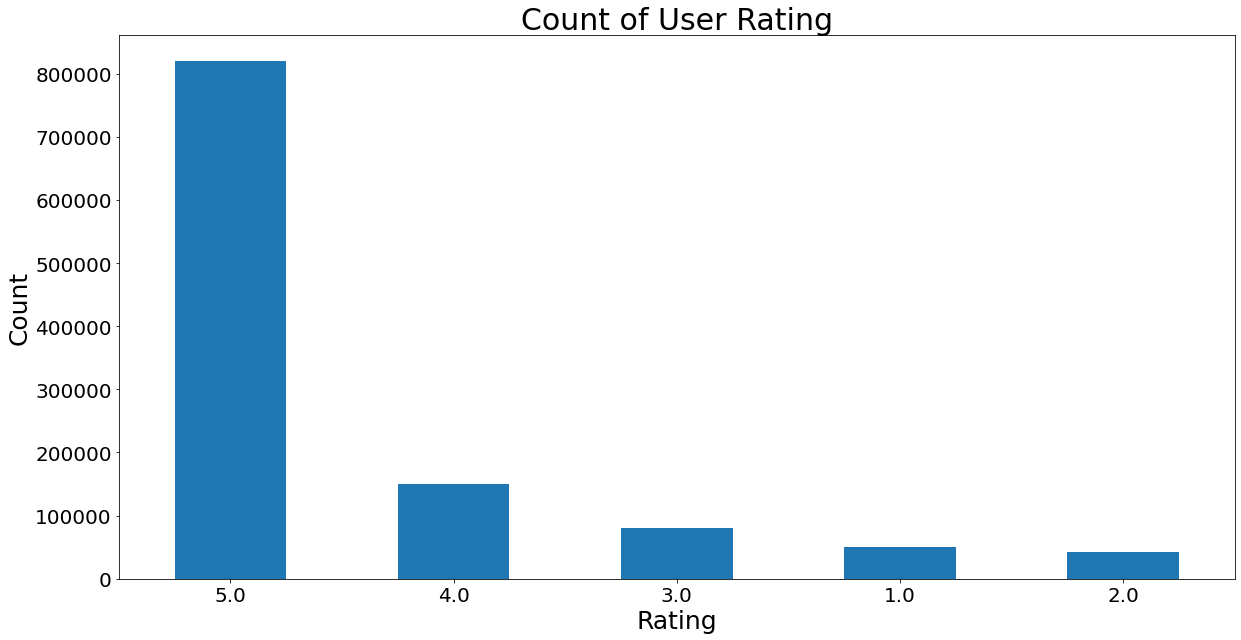

In [26]:
plt.figure(figsize=(20,10))
df['rating'].value_counts().plot.bar(rot=0)

plt.title('Count of User Rating',fontsize=30)
plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)

# Natural Language Processing (NLP)

Using natural language tool kit (NLTK) which is the most popular NLP libraries in Python, we're going to analyze the natural human language for all the amazon reviews in our data.

In [27]:
# strip '/n' characters from title and description
df['summary'] = df['summary'].apply(lambda x:x.strip('\n'))

# was getting an error when stripping review_description due to N/A (row 56)
df['review'][df['review'].isna()]
df['review'] = df['review'].fillna('-1')
df['review'] = df['review'].apply(lambda x:x.strip('\n'))

In [28]:
def clean_text(text):
    
    cleaned_text = "".join([x for x in text if x not in string.punctuation]) # remove punctuation
    cleaned_text = cleaned_text.lower() # lowercase all characters
    cleaned_text = cleaned_text.strip() # strip whitespace
    cleaned_text = re.sub('[0-9]+', '', cleaned_text)
    
    # remove all emojis
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    cleaned_text = deEmojify(cleaned_text)
    
    tokens = cleaned_text.split(" ") # split string into list of words
    
    STOPWORDS=stopwords.words("english") # stopwords - commonly used words eg is, he, we, etc.
    cleaned_text = [token for token in tokens if token not in STOPWORDS] # filter out stopwords
    

    return ' '.join(cleaned_text)

## Tokenization

In [29]:
# tokenize the data
df['clean_summary'] = df['summary'].apply(lambda x:clean_text(x))

In [30]:
df['clean_review'] = df['review'].apply(lambda x:clean_text(x))

In [31]:
df.head()

,rating,verified,reviewer_id,asin,reviewer_name,review,summary,time,clean_summary,clean_review
0,5.0,True,A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,2014-11-19,five stars,adverse comment
1,5.0,True,A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,2016-10-13,great product,gift college student
2,5.0,True,A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,2015-11-21,strong,like strong tea might even little strong
3,5.0,True,A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,2015-08-12,great tea,love tea flavor way better regular lipton blac...
4,5.0,True,A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,2015-05-28,tea remembered,searched everywhere browsed amazon found tea ...


In [32]:
list(df['clean_summary'])[:10]

['five stars',
 'great product',
 'strong',
 'great tea',
 'tea remembered',
 'four stars',
 'love tea',
 'great tea',
 'well bought tea malaysia',
 'really like tea']

In [33]:
list(df['clean_review'])[:10]

['adverse comment',
 'gift college student',
 'like strong tea might even little strong',
 'love tea flavor way better regular lipton black tea definetly worth money',
 'searched everywhere browsed amazon found  tea lipton selling grocery store shelves  stuff last purchased awful nowhere near good remember',
 'tea made lipton yellow label teabags much better tea made regular lipton teabags',
 'love tea  okay im high falutin tea snob first enjoyed lipton yellow label tea trip singapore whether room service company country  left favorable impression search whenever possible  maybe usas white label lipton tea yellow label tea appears smoother mellow  would highly recommend  give try',
 'discovered tea local med resta great tea sharing friends  everyone likes ordering  thanks amazon carrying tea otherwise available live',
 'well bought tea malaysia several months mostly try making teh tarik without using loose tea several times failed regular lipton black tea thought difference must yellow

In [34]:
df.to_csv('df_step1.csv',header=True,index=False)

## Lemmatization

In [35]:
# normalizes each word in review to its base form
# lemmatize takes part of speech parameter, if not supplied, default is noun
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

In [36]:
df['clean_review'] = df['clean_review'].apply(lambda x: ' '.join(lemmatize_sentence(x.split())))
df['clean_review']

0                                            adverse comment
1                                       gift college student
2                   like strong tea might even little strong
3          love tea flavor way good regular lipton black ...
4          search everywhere browse amazon find tea lipto...
                                 ...                        
1143855    new vegan sometimes difficult resist old tempt...
1143856    best thing ever order product cant find anywhe...
1143857    use love ranch become vegan one condiment take...
1143858       cannot dairy gluten close ranch ever able good
1143859          need improvement make taste like real ranch
Name: clean_review, Length: 1143155, dtype: object

In [37]:
list(df['clean_review'])[:10]

['adverse comment',
 'gift college student',
 'like strong tea might even little strong',
 'love tea flavor way good regular lipton black tea definetly worth money',
 'search everywhere browse amazon find tea lipton sell grocery store shelf stuff last purchased awful nowhere near good remember',
 'tea make lipton yellow label teabags much good tea make regular lipton teabags',
 'love tea okay im high falutin tea snob first enjoy lipton yellow label tea trip singapore whether room service company country leave favorable impression search whenever possible maybe usas white label lipton tea yellow label tea appear smooth mellow would highly recommend give try',
 'discover tea local med resta great tea share friend everyone like order thanks amazon carry tea otherwise available live',
 'well bought tea malaysia several month mostly try make teh tarik without use loose tea several time fail regular lipton black tea think difference must yellow label turn wrong problem condense milk clearly 

In [38]:
df.to_csv('df_step_2.csv',header=True,index=False)

## Unigram - Individual Words

### Common Words for Reviews

In [39]:
# convert dataframe series into frequency distribution
def convert_df_column_as_freq_dist(dataframe,column,no_common_words=10):

    word_dict = []

    for row in dataframe[column]:
        split_row = str(row).split()
        for word in split_row:
            word_dict.append(word)
            
    title_freqdist = FreqDist(word_dict)
    
    return title_freqdist.most_common(no_common_words)

In [40]:
most_common_words_reviews = dict(convert_df_column_as_freq_dist(df,'clean_review',no_common_words=20))
most_common_words_reviews

{'good': 412919,
 'taste': 355302,
 'like': 308056,
 'great': 291898,
 'flavor': 269615,
 'love': 243368,
 'use': 228388,
 'make': 195668,
 'product': 182085,
 'one': 175385,
 'tea': 171219,
 'coffee': 168670,
 'get': 158582,
 'buy': 152805,
 'try': 131218,
 'really': 112470,
 'price': 111622,
 'find': 106889,
 'would': 104676,
 'time': 101590}

<BarContainer object of 20 artists>

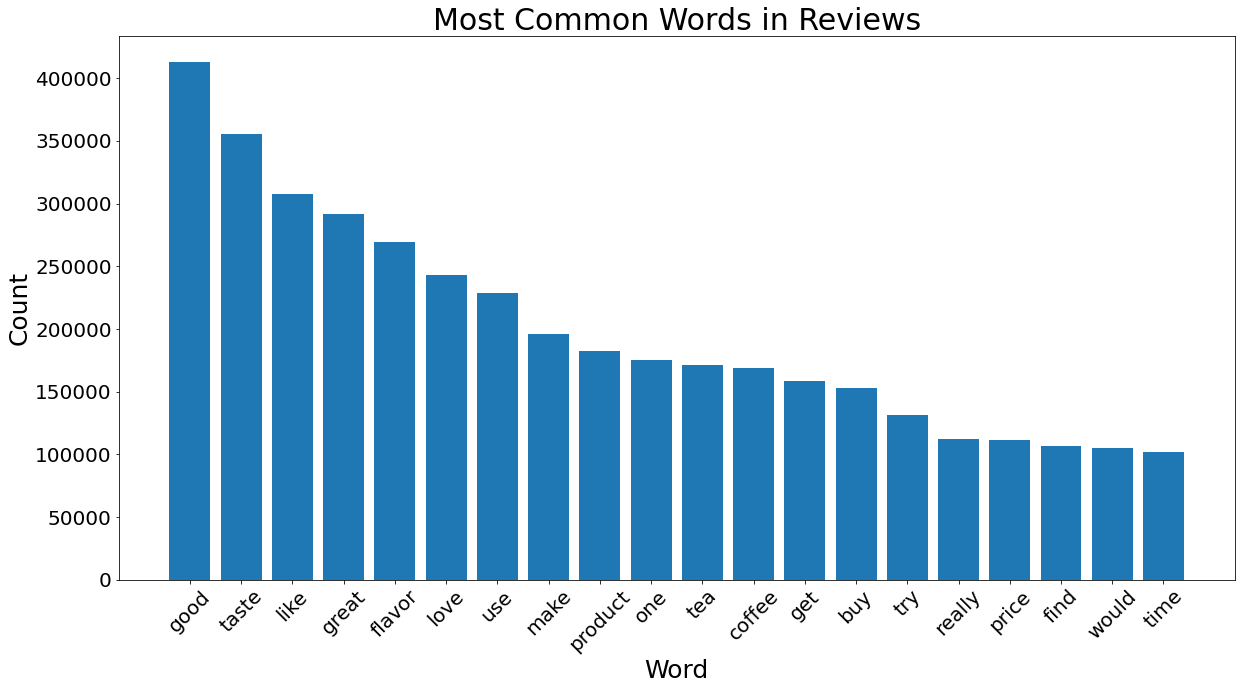

In [41]:
keys = most_common_words_reviews.keys()
values = most_common_words_reviews.values()

plt.figure(figsize=(20,10))
plt.title('Most Common Words in Reviews',fontsize=30)

plt.xlabel('Word',fontsize=25)
plt.xticks(fontsize=20, rotation=45)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)

plt.bar(keys, values)

### WordCloud for Most Common Words in Reviews

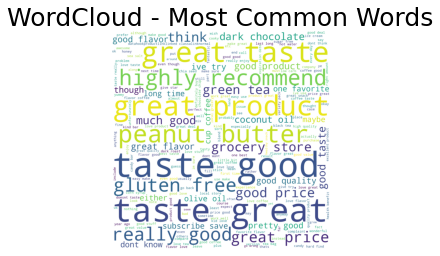

In [42]:
from wordcloud import WordCloud
wordcloud_reviews = WordCloud(height=2000, width=2000, background_color='white')
wordcloud_reviews = wordcloud_reviews.generate(' '.join(df['clean_review'].tolist()))
plt.imshow(wordcloud_reviews)
plt.title("WordCloud - Most Common Words", fontsize=25)
plt.axis('off')
plt.show()

# Bigrams

In [43]:
# convert dataframe column into a bag of words
def convert_df_column_as_freq_dist_bigrams(dataframe,column, reverse_order=True, no_of_bigrams=10):
    
    import itertools

    bigrams_dict = {}

    for row in dataframe[column]:
        nltk_token = nltk.word_tokenize(row)
        bigram = list(nltk.bigrams(nltk_token))
        for pair_bigram in bigram:
            if pair_bigram in bigrams_dict:
                bigrams_dict[pair_bigram] += 1
            else:
                bigrams_dict[pair_bigram] = 1 
    
    sorted_bigrams_dict = {k: v for k, v in sorted(bigrams_dict.items(), 
                                    key=lambda item: item[1],
                                    reverse=reverse_order)}
    
    return dict(itertools.islice(sorted_bigrams_dict.items(), no_of_bigrams))

In [44]:
# outputs the most common bigrams as a dictionary of frequency distribution
most_common_bigrams = convert_df_column_as_freq_dist_bigrams(df,'clean_review',
                                                             reverse_order=True,
                                                             no_of_bigrams=20)
most_common_bigrams

{('taste', 'like'): 38285,
 ('taste', 'good'): 32430,
 ('taste', 'great'): 28959,
 ('great', 'taste'): 21920,
 ('great', 'product'): 21466,
 ('peanut', 'butter'): 16539,
 ('gluten', 'free'): 16534,
 ('highly', 'recommend'): 16524,
 ('really', 'good'): 16109,
 ('great', 'price'): 15316,
 ('good', 'price'): 15081,
 ('grocery', 'store'): 14864,
 ('green', 'tea'): 14353,
 ('really', 'like'): 14143,
 ('much', 'good'): 14138,
 ('dark', 'chocolate'): 12158,
 ('good', 'taste'): 11934,
 ('good', 'product'): 11829,
 ('coconut', 'oil'): 11627,
 ('great', 'flavor'): 11536}

<BarContainer object of 20 artists>

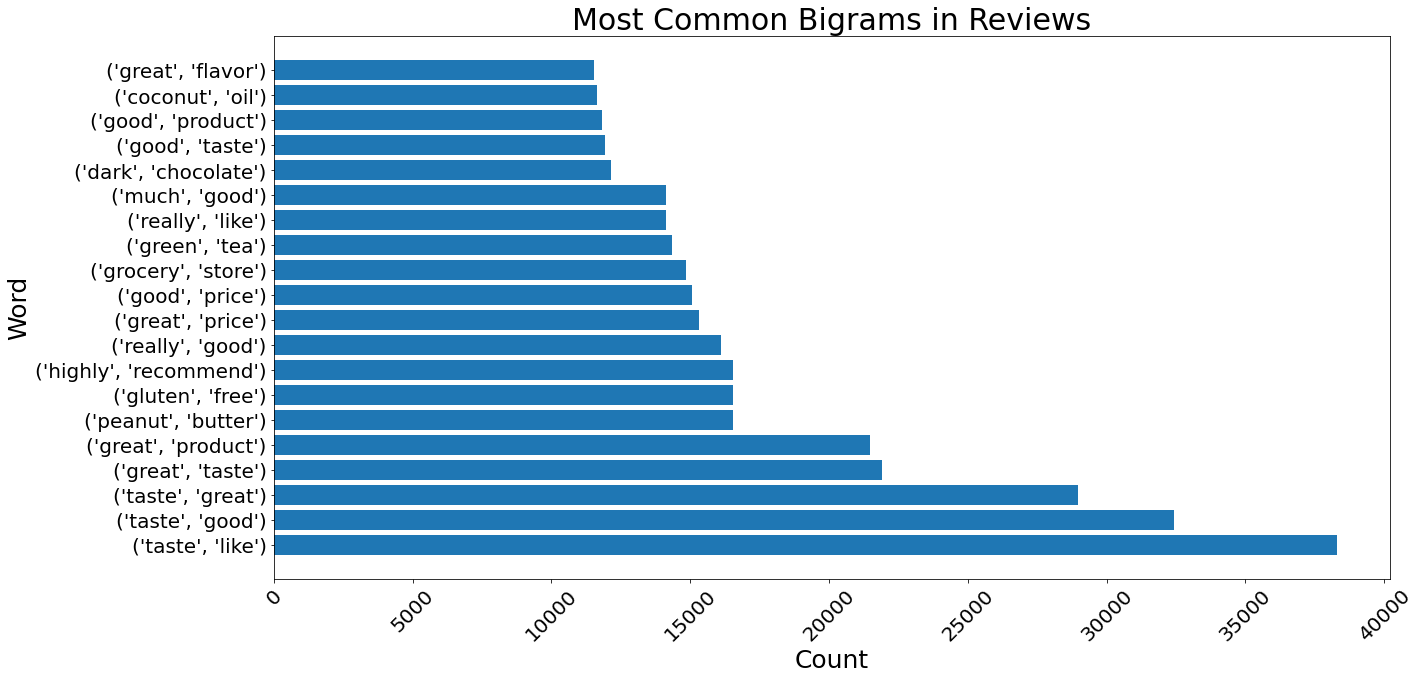

In [45]:
keys = [str(key) for key in most_common_bigrams.keys()]
values = most_common_bigrams.values()

plt.figure(figsize=(20,10))
plt.title('Most Common Bigrams in Reviews',fontsize=30)

plt.xlabel('Count',fontsize=25)
plt.xticks(fontsize=20, rotation=90)
plt.ylabel('Word',fontsize=25,)
plt.yticks(fontsize=20)
plt.tick_params(axis='x',labelsize=20,rotation=45)

plt.barh(keys, values)

# Most Common Positive and Negative Words

In [46]:
# import lexicon positive english words
lexicon_positive_words = []
positive_file = open('opinion-lexicon-English/positive-words.txt', 'r')
for line in positive_file.readlines()[35:]:
    lexicon_positive_words.append(line.strip())

# import lexicon negative english words
lexicon_negative_words = []
negative_file = open('opinion-lexicon-English/negative-words.txt', 'r', encoding = "ISO-8859-1")
for line in negative_file.readlines()[35:]:
    lexicon_negative_words.append(line.strip())

In [47]:
# count the most common words in all reviews
word_counter = dict(convert_df_column_as_freq_dist(df,'clean_review',no_common_words=10000))

In [48]:
# outputs a dictionary of most common positive words in reviews
positive_words = {}
for keyvalue in word_counter.items():
    key = keyvalue[0]
    value = keyvalue[1]
    # if positive words from reviews are in the positive lexicon english words, add to positive_words dictionary
    if key in lexicon_positive_words:
        positive_words[key] = value
        
        

# outputs a dictionary of most common negative words in reviews
negative_words = {}
for keyvalue in word_counter.items():
    key = keyvalue[0]
    value = keyvalue[1]
    # if negative words from reviews are in the negative lexicon english words, add to negative_words dictionary
    if key in lexicon_negative_words:
        negative_words[key] = value

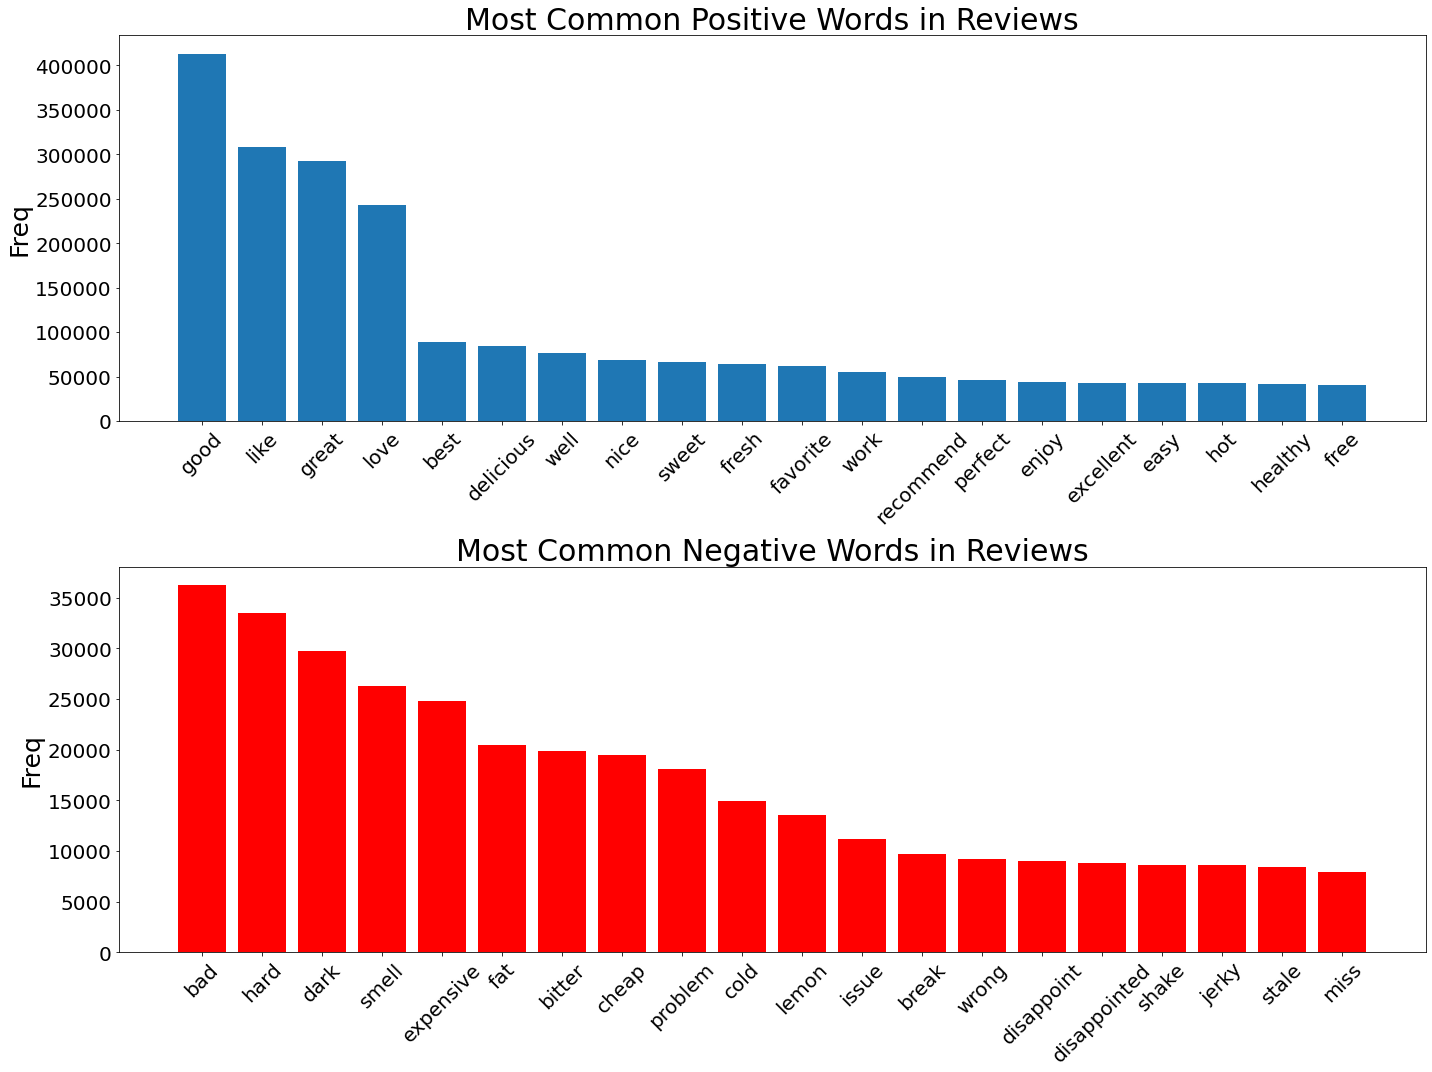

In [49]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,15 ## Sets the height and width of image

fig,ax=plt.subplots(2,1)

top_20_positive_words = dict(list(positive_words.items())[:20])
keys = top_20_positive_words.keys()
values = top_20_positive_words.values()
ax[0].bar(keys, values)
ax[0].set_title('Most Common Positive Words in Reviews',fontsize=30)
# ax[0].set_xlabel('Word',fontsize=25)
ax[0].set_ylabel('Freq',fontsize=25)
ax[0].tick_params(axis='x',labelsize=20,rotation=45)
ax[0].tick_params(axis='y',labelsize=20);

top_20_negative_words = dict(list(negative_words.items())[:20])
keys = top_20_negative_words.keys()
values = top_20_negative_words.values()
ax[1].bar(keys, values,color='red')
# ax[1].bar(keys, values)
ax[1].set_title('Most Common Negative Words in Reviews',fontsize=30)
# ax[1].set_xlabel('Word',fontsize=25)
ax[1].set_ylabel('Freq',fontsize=25)
ax[1].tick_params(axis='x',labelsize=20,rotation=45)
ax[1].tick_params(axis='y',labelsize=20)

fig.tight_layout()


## WordCloud - Most Common Words in Positive Reviews

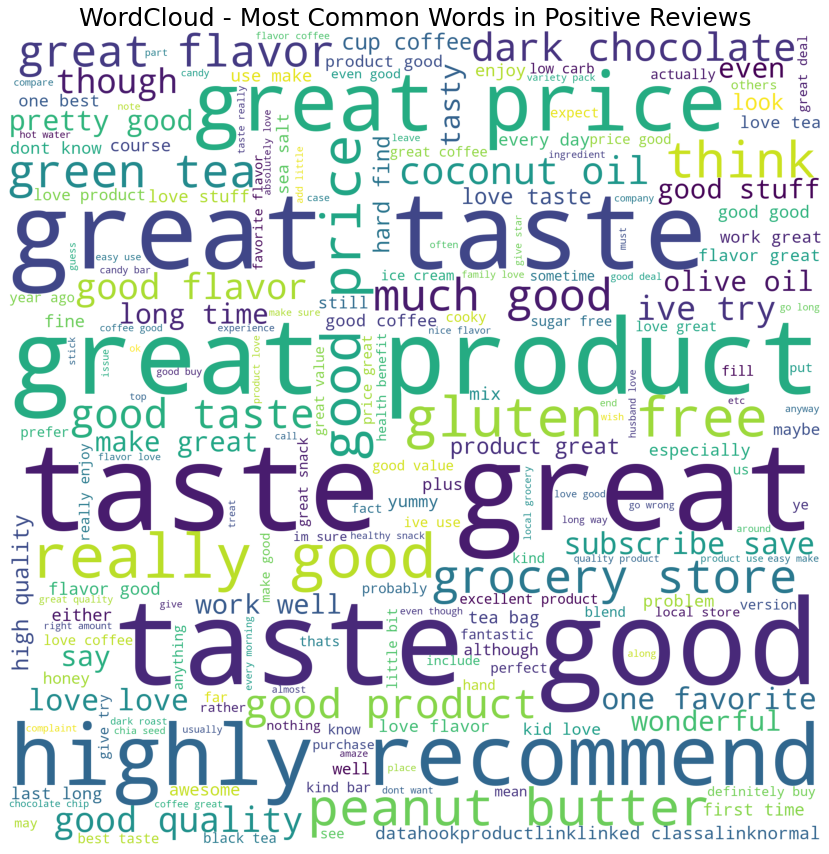

In [51]:
from wordcloud import WordCloud
wordcloud_reviews = WordCloud(height=2000, width=2000, background_color='white')
wordcloud_reviews = wordcloud_reviews.generate(' '.join(df[df['rating'] >= 4]['clean_review'].tolist()))
plt.imshow(wordcloud_reviews)
plt.title("WordCloud - Most Common Words in Positive Reviews", fontsize=25)
plt.axis('off')
plt.show()

## WordCloud - Most Common Words in Negative Reviews

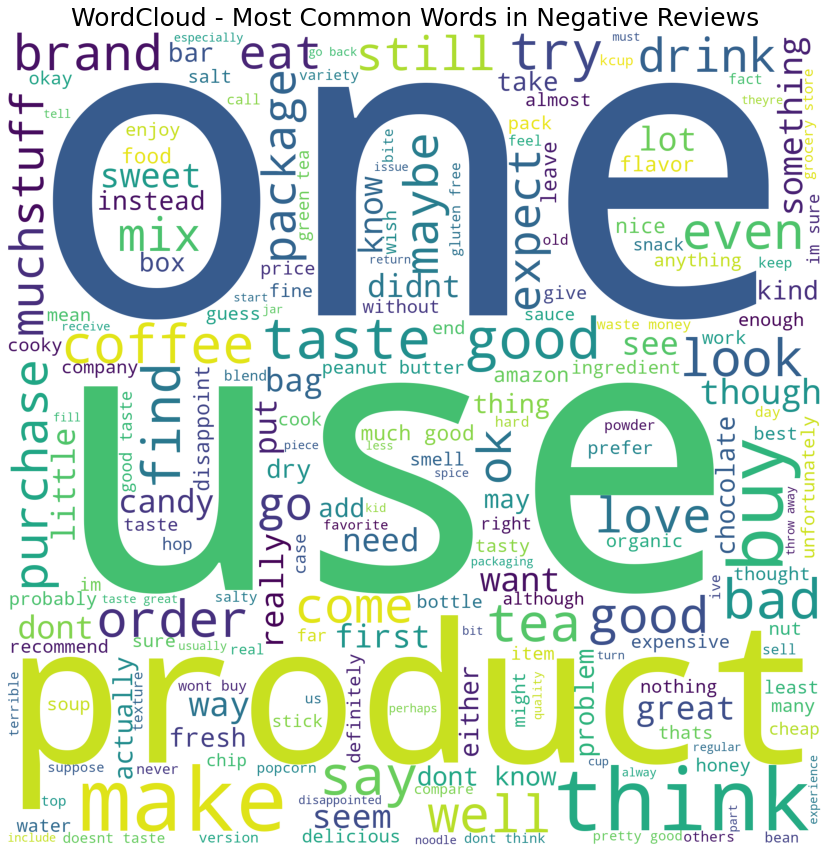

In [52]:
from wordcloud import WordCloud
wordcloud_reviews = WordCloud(height=2000, width=2000, background_color='white')
wordcloud_reviews = wordcloud_reviews.generate(' '.join(df[df['rating'] < 4]['clean_review'].tolist()))
plt.imshow(wordcloud_reviews)
plt.title("WordCloud - Most Common Words in Negative Reviews", fontsize=25)
plt.axis('off')
plt.show()

# Count of Reviews for each Item

In [53]:
# number of user_ratings for each board game
table = pd.pivot_table(df, index=['asin'], columns=['rating'],
                       aggfunc='count',
                       fill_value=0.0)['clean_review']
table['total'] = table[1.0] + table[2.0] + table[3.0] + table[4.0] + table[5.0]
table

rating,1.0,2.0,3.0,4.0,5.0,total
asin,,,,,,
4639725043,2,0,5,6,17,30
4639725183,0,0,0,2,10,12
5463213682,0,0,0,1,8,9
9742356831,2,4,6,11,73,96
B00004S1C5,1,0,4,2,7,14
...,...,...,...,...,...,...
B01HJ2OFYI,1,0,1,1,9,12
B01HJ4FWGG,0,1,3,1,13,18
B01HJ7QPKU,0,1,1,1,5,8
